## Installing Dependencies

In [ ]:
! pip install numpy pandas matplotlib

## Loading the data

In [ ]:
import pandas as pd

trips=pd.read_csv("fhvhv_tripdata_2025-07.csv")

zones=pd.read_csv("taxi_zones_toysample_TableToExcel_csv.csv")
#extract zones
selected_zones_ids=zones["LocationID"].tolist()

print(selected_zones_ids)



[25, 33, 45, 65, 66, 87, 88, 209]


## Filtering trips based on start and end location so they only occure within selected zone ids:

In [ ]:
#exrtact trips within zones
filtered_trips=trips[trips["pulocationid"].isin(selected_zones_ids) & trips["dolocationid"].isin(selected_zones_ids)]

In [ ]:
print("Original trip count:", len(trips))
print("Filtered trip count:", len(filtered_trips))
filtered_trips[["pulocationid", "dolocationid"]].head()

#save filtered trips

filtered_trips.to_csv("filtered_fhvhv_trips.csv", index=False)


Original trip count: 10783920
Filtered trip count: 39852


## Adding noise on start and end location of trips

In [ ]:
import pandas as pd
import numpy as np

# Load data
trips = pd.read_csv("filtered_fhvhv_trips.csv")
zones = pd.read_csv("taxi_zones_toysample_TableToExcel_csv.csv")

# Ensure types align
trips["pulocationid"] = trips["pulocationid"].astype(int)
trips["dolocationid"] = trips["dolocationid"].astype(int)
zones["LocationID"] = zones["LocationID"].astype(int)

# Build centroid lookup
centroids = zones.set_index("LocationID")[["centroid_x", "centroid_y"]].to_dict("index")

# Reproducible noise
rng = np.random.default_rng(42)

# --- choose a jitter scale (feet) ---
# Manhattan block ≈ 250–900 ft; 300–600 ft keeps points “near” the center.
DEFAULT_SIGMA_FT = 500.0  # std dev of Gaussian noise in feet

def jitter_xy(loc_id, sigma_ft=DEFAULT_SIGMA_FT):
    cx = centroids[loc_id]["centroid_x"]
    cy = centroids[loc_id]["centroid_y"]
    # Isotropic Gaussian jitter
    jx = rng.normal(0.0, sigma_ft)
    jy = rng.normal(0.0, sigma_ft)
    return cx + jx, cy + jy

# Apply to trips
pu_xy = trips["pulocationid"].map(lambda z: jitter_xy(int(z)))
do_xy = trips["dolocationid"].map(lambda z: jitter_xy(int(z)))

trips["pu_x"], trips["pu_y"] = zip(*pu_xy)
trips["do_x"], trips["do_y"] = zip(*do_xy)

# Save
trips.to_csv("filtered_fhvhv_trips_with_jitter.csv", index=False)
print("Saved with jittered coordinates.")


Saved with jittered coordinates.


## Filtering the data by time i.e choossing from July 7st to July 11th(12-14 hrs trips) for calculating Demand and July 14th for Test data(12-14 hrs trips)

In [ ]:
import pandas as pd
from datetime import date

SRC = "filtered_fhvhv_trips_with_jitter.csv"  # your trips file

# ------------ Load & parse time ------------
df = pd.read_csv(SRC)
time_col = "request_datetime"


df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col]).copy()

# Ensure needed columns exist
required_cols = {"pulocationid"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Convenience columns
df["date"] = df[time_col].dt.date
df["hour"] = df[time_col].dt.hour

# ------------ CONFIG ------------
# Demand (phi) window: 5 days, 18:00–20:00
DEMAND_START = date(2025, 7, 7)
DEMAND_END   = date(2025, 7, 11)  # inclusive
DEMAND_HOUR_START = 18
DEMAND_HOUR_END   = 20   # exclusive

# Test window: single day (not in demand window), 18:00–20:00
TEST_DAY = date(2025, 7, 14)
TEST_HOUR_START = 18
TEST_HOUR_END   = 20

# ------------ 1) Build φ from July 7–11, 18–20 ------------
mask_demand_dates = (df["date"] >= DEMAND_START) & (df["date"] <= DEMAND_END)
mask_demand_hours = (df["hour"] >= DEMAND_HOUR_START) & (df["hour"] < DEMAND_HOUR_END)
df_demand = df.loc[mask_demand_dates & mask_demand_hours].copy()

# 15-min bins and a label like "HH:MM"
df_demand["bin15"] = df_demand[time_col].dt.floor("15min")
df_demand["time_bin_label"] = df_demand["bin15"].dt.strftime("%H:%M")

# Count requests per (zone, bin15, date)
grouped = (
    df_demand.groupby(["pulocationid", "time_bin_label", "date"])
             .size()
             .reset_index(name="requests")
)

# Average across days → φ per (zone, time_bin_label)
phi_table = (
    grouped.groupby(["pulocationid", "time_bin_label"])["requests"]
           .mean()
           .reset_index()
           .rename(columns={"pulocationid": "zone", "requests": "avg_requests"})
           .sort_values(["zone", "time_bin_label"])
)

phi_out = "phi_avg_15min_Jul7to11_18to20.csv"
phi_table.to_csv(phi_out, index=False)
print(f"[OK] Saved φ table → {phi_out}")
print(phi_table.head(10))

# ------------ 2) Test trips for July 14, 18–20 ------------
mask_test_date  = (df["date"] == TEST_DAY)
mask_test_hours = (df["hour"] >= TEST_HOUR_START) & (df["hour"] < TEST_HOUR_END)
df_test = df.loc[mask_test_date & mask_test_hours].copy()

test_out = "test_trips_Jul14_18to20.csv"
df_test.to_csv(test_out, index=False)
print(f"[OK] Saved test trips → {test_out}")
print(df_test[[time_col, "pulocationid"]].head(10))


[OK] Saved φ table → phi_avg_15min_Jul7to11_18to20.csv
   zone time_bin_label  avg_requests
0    25          18:00          6.60
1    25          18:15          7.25
2    25          18:30          8.40
3    25          18:45          9.80
4    25          19:00          8.40
5    25          19:15          8.40
6    25          19:30          6.40
7    25          19:45         11.00
8    33          18:00          8.40
9    33          18:15          9.40
[OK] Saved test trips → test_trips_Jul14_18to20.csv
         request_datetime  pulocationid
31179 2025-07-14 18:18:22            25
31180 2025-07-14 18:40:00           209
31181 2025-07-14 18:51:37            65
31182 2025-07-14 18:43:03            88
31183 2025-07-14 18:01:35            25
31184 2025-07-14 18:34:10            88
31185 2025-07-14 18:21:24            33
31187 2025-07-14 18:08:45            33
31188 2025-07-14 18:51:32            88
31189 2025-07-14 18:41:48            33


## distribution of trips per minute

           minute_bin  num_trips
0 2025-07-14 18:00:00          4
1 2025-07-14 18:01:00          4
2 2025-07-14 18:02:00          2
3 2025-07-14 18:03:00          3
4 2025-07-14 18:04:00          2
5 2025-07-14 18:05:00          3
6 2025-07-14 18:06:00          1
7 2025-07-14 18:07:00          2
8 2025-07-14 18:08:00          3
9 2025-07-14 18:09:00          1


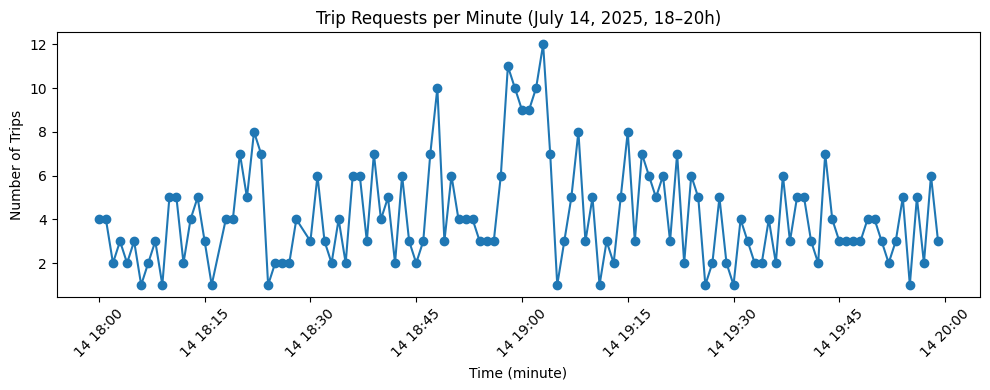

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the already filtered test data ---
df_test = pd.read_csv("test_trips_Jul14_18to20.csv")

# Parse datetime column
time_col = "request_datetime"
df_test[time_col] = pd.to_datetime(df_test[time_col], errors="coerce")

# --- Group trips per minute ---
df_test["minute_bin"] = df_test[time_col].dt.floor("min")
per_min = df_test.groupby("minute_bin").size().reset_index(name="num_trips")

# --- Print sample and plot ---
print(per_min.head(10))

plt.figure(figsize=(10, 4))
plt.plot(per_min["minute_bin"], per_min["num_trips"], marker="o")
plt.title("Trip Requests per Minute (July 14, 2025, 18–20h)")
plt.xlabel("Time (minute)")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Checking if there are timestamps with no trips at all

In [ ]:
import pandas as pd

# --- assuming df_test and per_min already exist ---
start_time = df_test["request_datetime"].min().floor("min")
end_time   = df_test["request_datetime"].max().ceil("min")

# Generate all expected minute bins in that range
all_minutes = pd.date_range(start=start_time, end=end_time, freq="1min")

# Merge to find missing minutes
per_min_full = pd.DataFrame({"minute_bin": all_minutes}).merge(
    per_min, on="minute_bin", how="left"
).fillna({"num_trips": 0})

# Find minutes with zero trips
no_trip_minutes = per_min_full.loc[per_min_full["num_trips"] == 0, "minute_bin"]

print(f"Total minutes in window: {len(per_min_full)}")
print(f"Minutes with NO trips: {len(no_trip_minutes)}")

if not no_trip_minutes.empty:
    print("\nExample missing minutes:")
    print(no_trip_minutes.head(10))
else:
    print("\n✅ Every minute has at least one trip.")


Total minutes in window: 121
Minutes with NO trips: 3

Example missing minutes:
17    2025-07-14 18:17:00
29    2025-07-14 18:29:00
120   2025-07-14 20:00:00
Name: minute_bin, dtype: datetime64[ns]


## Main Loop

In [1]:
# I am using Colab so I add this code block to install gurobipy & connect my google drive for importing datasets
# !pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# main_loop_inputs_minimal.py
# Build model inputs per minute (c1, c2, c3, phi, gamma, impact)
# Uses: test_trips_Jul14_18to20.csv (main loop), phi_avg_15min_Jul7to11_18to20.csv (demand)

import numpy as np
import pandas as pd

# --------------------------
# Config (paths)
# --------------------------
# REQS_CSV   = "test_trips_Jul14_18to20.csv"              # <-- TEST DATA for main loop
# ZONES_CSV  = "taxi_zones_toysample_TableToExcel_csv.csv"
# PHI_CSV    = "phi_avg_15min_Jul7to11_18to20.csv"        # <-- DEMAND DATA (averaged over Jul 7–11)
REQS_CSV   = "test_trips_Jul14_18to20.csv"
ZONES_CSV  = "taxi_zones_toysample_TableToExcel_csv.csv"
PHI_CSV    = "phi_avg_15min_Jul7to11_18to20.csv"
FLEET_SIZE = 32
REBAL_ONLY_MATCH_REQ = True
SEED  = 42
BIG_M = 1e9
Tprime_sec = 15 * 60.0

rng = np.random.default_rng(SEED)

# --------------------------
# Load trips (already filtered test set)
# --------------------------
df = pd.read_csv(REQS_CSV)
df["request_datetime"]  = pd.to_datetime(df["request_datetime"],  errors="coerce")
df["pickup_datetime"]   = pd.to_datetime(df["pickup_datetime"],   errors="coerce")
df["dropoff_datetime"]  = pd.to_datetime(df["dropoff_datetime"],  errors="coerce")
df = df.dropna(subset=["request_datetime"]).copy()

# Normalize column name references
cols = {c.lower(): c for c in df.columns}
PU_ID, DO_ID = cols["pulocationid"], cols["dolocationid"]
PU_X, PU_Y   = cols["pu_x"], cols["pu_y"]
DO_X, DO_Y   = cols["do_x"], cols["do_y"]

# Sort & minute bins (for batching)
df = df.sort_values("request_datetime").reset_index(drop=True)
df["minute_bin"] = df["request_datetime"].dt.floor("min")

# Durations (minutes)
# Keep timestamps as-is for batching; only convert durations to MINUTES (ceil)
df["wait_min"] = np.ceil((df["pickup_datetime"]  - df["request_datetime"]).dt.total_seconds() / 60.0)
df["trip_min"] = np.ceil((df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds()  / 60.0)

# Clean invalids: enforce at least 1 minute for any nonpositive/missing values
df.loc[(df["wait_min"].isna()) | (df["wait_min"] <= 0), "wait_min"] = 1.0
df.loc[(df["trip_min"].isna()) | (df["trip_min"] <= 0), "trip_min"] = 1.0
# --------------------------
# Zones (as-is)
# --------------------------
zones = (
    pd.read_csv(ZONES_CSV)
      [["LocationID", "centroid_x", "centroid_y"]]
      .drop_duplicates()
      .rename(columns={"LocationID": "zone"})
)
zones["zone"] = zones["zone"].astype(int)
zones = zones.sort_values("zone").reset_index(drop=True)

zone_ids     = zones["zone"].tolist()
Z            = len(zone_ids)
zone_to_idx  = {z: i for i, z in enumerate(zone_ids)}
zones_mat    = zones.set_index("zone").loc[zone_ids, ["centroid_x", "centroid_y"]].to_numpy(float)

# --------------------------
# φ (avg demand per zone × 15-min bin) — precomputed from Jul 7–11, 18–20
# --------------------------
phi_tbl = pd.read_csv(PHI_CSV)
# Accept either 'pulocationid' or 'zone' as zone column
if "zone" not in phi_tbl.columns and "pulocationid" in phi_tbl.columns:
    phi_tbl = phi_tbl.rename(columns={"pulocationid": "zone"})
phi_tbl["zone"] = phi_tbl["zone"].astype(int)

def fifteen_bin_label(ts):
    return pd.to_datetime(ts).floor("15min").strftime("%H:%M")

def phi_vector(tstamp):
    lbl = fifteen_bin_label(tstamp)
    s = phi_tbl.loc[phi_tbl["time_bin_label"] == lbl].set_index("zone")["avg_requests"]
    return np.array([float(s.get(z, 0.0)) for z in zone_ids], dtype=float)

# --------------------------
# Initialize fleet evenly (centroid jitter for uniqueness)
# --------------------------
per_zone = [FLEET_SIZE // Z] * Z
for i in range(FLEET_SIZE % Z):
    per_zone[i] += 1

vehicles = []
vid = 0
for zid, n in zip(zone_ids, per_zone):
    cx, cy = zones_mat[zone_to_idx[zid]]
    for _ in range(n):
        vehicles.append(dict(
            id=vid,
            x=cx + rng.normal(0, 20.0),
            y=cy + rng.normal(0, 20.0),
            zone=zid,
            state="idle",   # idle | rebalancing | enroute | ontrip
        ))
        vid += 1
vehicles = pd.DataFrame(vehicles)

# --------------------------
# Main loop: per-minute batches → build inputs
# Skip minutes with no requests
# --------------------------
unique_minutes = df["minute_bin"].dropna().sort_values().unique()
print(f"Total unique minutes with requests: {len(unique_minutes)}")
epochs = []

for t in unique_minutes[0:1]:
    Rt = df.loc[df["minute_bin"] == t].copy()
    R  = len(Rt)
    if R == 0:
        # No requests in this minute → skip building inputs
        continue

    # vehicle sets (no motion update here)
    idx_idle  = vehicles.index[vehicles["state"] == "idle"].to_list()
    idx_rebal = vehicles.index[vehicles["state"] == "rebalancing"].to_list()
    VI, VB    = len(idx_idle), len(idx_rebal)

    # --- c1: idle vehicles → requests (Euclidean)
    # ---Only compute if you have at least one idle vehicle and at least one request in the current batch (R = len(Rt)).
    if VI > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
        diffs = v_xy[:, None, :] - r_xy[None, :, :]
        c1 = np.sqrt((diffs ** 2).sum(axis=2))  # (|V_I|, |R|)
    else:
        c1 = np.zeros((0, R), dtype=float)

    # --- c2: idle vehicles → zone centroids
    # ---Only compute if you have at least one idle vehicle.
    if VI > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        diffs = v_xy[:, None, :] - zones_mat[None, :, :]
        c2 = np.sqrt((diffs ** 2).sum(axis=2))  # (|V_I|, |Z|)
    else:
        c2 = np.zeros((0, Z), dtype=float)

    # --- c3: (idle ∪ rebalancing) vehicles → (requests ∪ zones)
    # --- Build the full candidate vehicle set (idle + rebalancing) for the integrated problem.
    Vstar_idx = idx_idle + idx_rebal
    Vstar = len(Vstar_idx)
    J = R + Z
    if Vstar > 0:
        v_xy = vehicles.loc[Vstar_idx, ["x", "y"]].to_numpy(float)
        c3 = np.zeros((Vstar, J), dtype=float)

        # to requests
        r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
        diffr = v_xy[:, None, :] - r_xy[None, :, :]
        c3[:, :R] = np.sqrt((diffr ** 2).sum(axis=2))

        # to zones
        diffz = v_xy[:, None, :] - zones_mat[None, :, :]
        c3[:, R:] = np.sqrt((diffz ** 2).sum(axis=2))

        # forbid rebalancing vehicles from choosing zone columns (if desired)
        # optional: rebalancing vehicles cannot choose zone columns
        # --- Policy toggle: if REBAL_ONLY_MATCH_REQ is True, then rebalancing vehicles are forbidden from choosing zone columns.
        # --- Technically, you “forbid” by assigning a very large cost (BIG_M) to their zone-choice columns.
        if REBAL_ONLY_MATCH_REQ and VB > 0:
            reb_rows = [Vstar_idx.index(i) for i in idx_rebal]
            c3[np.ix_(reb_rows, list(range(R, R + Z)))] = BIG_M
    else:
        c3 = np.zeros((0, J), dtype=float)

    # --- φ for this epoch (from precomputed Jul7–11 averages)
    phi = phi_vector(pd.to_datetime(t))   # shape (Z,)

    # --- γ: simple proxy = count of idle vehicles per zone
    gamma = np.zeros(Z, dtype=float)
    for i in idx_idle:
        gamma[zone_to_idx[vehicles.at[i, "zone"]]] += 1.0

    # --- impact: (|V*|, |R|+|Z|, |Z|)
    # requests: departure -1 at current zone; arrival credit uses real durations m_j = wait_sec + trip_sec
    # zones:    departure -1 at current zone; no arrival credit (no time model here)
    impact = np.zeros((Vstar, J, Z), dtype=float)
    if Vstar > 0:
        v_cur_zone_ids = [vehicles.at[i, "zone"] for i in Vstar_idx]
        v_cur_idx      = np.array([zone_to_idx[z] for z in v_cur_zone_ids], dtype=int)

        # Requests: departure -1 at current zone; arrival credit within 15-min horizon (IN MINUTES)
        if R > 0:
            do_zone_idx = Rt[DO_ID].map(zone_to_idx).to_numpy(int)
            # Total minutes from request to trip completion (integers, because you ceil’d)
            m_j_min = (Rt["wait_min"].to_numpy(float) + Rt["trip_min"].to_numpy(float))

            Tprime_min = 15.0  # horizon in minutes

            for jj in range(R):
                # departure loss at the vehicle's current zone
                impact[np.arange(Vstar), jj, v_cur_idx] += -1.0

                # arrival credit if completes within horizon (minutes)
                dur = m_j_min[jj]
                if dur > Tprime_min:
                    frac = 0.0
                else:
                    frac = max(0.0, (Tprime_min - dur) / Tprime_min)
                impact[np.arange(Vstar), jj, do_zone_idx[jj]] += frac

        # zone choices (rebalance): departure -1 only
        for jz in range(Z):
            col = R + jz
            impact[np.arange(Vstar), col, v_cur_idx] += -1.0

    # --- store epoch bundle ---
    epochs.append(dict(
        t=pd.to_datetime(t),
        request_batch=Rt.copy(),
        vehicles_snapshot=vehicles.copy(),
        idx_idle=idx_idle,
        idx_rebalancing=idx_rebal,
        c1=c1, c2=c2, c3=c3,
        phi=phi, gamma=gamma,
        impact=impact,
        zone_ids=zone_ids,
    ))

    print(f"[{t}] R={R} | |VI|={VI} | c1{c1.shape} c2{c2.shape} c3{c3.shape}")

    # gurobi part: our model
    V_I_t  = idx_idle
    V_B_t  = idx_rebal
    R_t    = list(range(R))
    Z_set  = list(range(Z))
    V_all  = list(set(V_I_t) | set(V_B_t))          # V_I^t ∪ V_B^t
    J_all  = list(set(R_t)    | set(Z_set))         # R^t ∪ Z
    P      = 1000.0
    alpha  = 50

    m = gp.Model("model_joint")
    m.Params.OutputFlag = 0
    x = m.addVars(V_all, J_all, vtype=GRB.BINARY, name="x")
    u = m.addVars(Z_set, lb=0.0, vtype=GRB.CONTINUOUS, name="u")
    w = m.addVars(Z_set, lb=0.0, vtype=GRB.CONTINUOUS, name="w")
    term_idle = gp.quicksum(c3[(v, j)] * x[v, j] for v in V_I_t for j in J_all)
    term_rebal = gp.quicksum(c3[(v, j)] * x[v, j] for v in V_B_t for j in R_t)
    unserved = P * gp.quicksum(1 - gp.quicksum(x[v, j] for v in V_all)for j in R_t)
    imbalance_penalty = alpha * (gp.quicksum(u[z] for z in Z_set) +gp.quicksum(w[z] for z in Z_set))
    m.setObjective(term_idle + term_rebal + unserved + imbalance_penalty, GRB.MINIMIZE)

    m.addConstrs((gp.quicksum(x[v, j] for v in V_all) <= 1 for j in J_all))
    m.addConstrs((gp.quicksum(x[v, j] for j in J_all) <= 1 for v in V_all))
    m.addConstrs((
        gamma[z] + gp.quicksum(impact[v,j,z] * x[v, j] for v in V_all for j in J_all) - phi[z] == w[z] - u[z] for z in Z_set
    ))
    m.optimize()

    if m.status == GRB.OPTIMAL:
        idle_to_request = {} # originally idle vehicles, assigned to requests
        idle_to_zone = {} # originally idle vehicles, assigned to zones
        for v in V_I_t:
            assigned = False
            for r in R_t:
                if x[v, r].X > 0.5:
                    idle_to_request[v] = r
                    assigned = True
                    break
            if not assigned:
                for z in Z_set:
                    if x[v, z].X > 0.5:
                        idle_to_zone[v] = z
                        assigned = True
                        break
        rebal_to_request = {} # originally rebal vehicles, assigned to requests
        rebal_unchanged = [] # originally rebal vehicles, not changed
        for v in V_B_t:
            matched_r = None
            for r in R_t:
                if x[v, r].X > 0.5:
                    matched_r = r
                    break
            if matched_r is None:
                rebal_unchanged.append(v)
            else:
                rebal_to_request[v] = matched_r
        new_idx_idle = [v for v in V_I_t if v not in idle_to_request and v not in idle_to_zone]
        idx_rebalancing = list(idle_to_zone.keys()) + list(rebal_unchanged)

    print("vehicle-request matching:", idle_to_request, rebal_to_request)
    print("vehicle-zone matching:", idle_to_zone)



    # todo: update vehicle status, store their locations (for metrics), and pass the necessary info for the next epoch


    # todo: calculate the system performance


Total unique minutes with requests: 118
[2025-07-14 18:00:00] R=4 | |VI|=32 | c1(32, 4) c2(32, 8) c3(32, 12)
vehicle-request matching: {2: 1, 14: 0, 16: 3, 26: 2} {}
vehicle-zone matching: {10: 6}


## FINAL JOINT MODEL:

### With all components i.e loading data, run the model, update vehicle status, evaluation metrics

In [6]:
# main_loop_joint.py
# Integrated (joint) matching + rebalancing model with simulation updates

import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# --------------------------
# Config (paths)
# --------------------------
REQS_CSV   = "test_trips_Jul14_18to20.csv"
ZONES_CSV  = "taxi_zones_toysample_TableToExcel_csv.csv"
PHI_CSV    = "phi_avg_15min_Jul7to11_18to20.csv"
FLEET_SIZE = 32
REBAL_ONLY_MATCH_REQ = True
SEED  = 42
BIG_M = 1e9
Tprime_sec = 15 * 60.0

# for converting Euclidean distance → minutes (for rebalancing legs)
AVG_SPEED_KMPH = 25.0
AVG_SPEED_M_PER_MIN = AVG_SPEED_KMPH * 1000.0 / 60.0

rng = np.random.default_rng(SEED)

# --------------------------
# Load trips (already filtered test set)
# --------------------------
df = pd.read_csv(REQS_CSV)

df["request_datetime"]  = pd.to_datetime(df["request_datetime"],  errors="coerce")
df["on_scene_datetime"] = pd.to_datetime(df["on_scene_datetime"], errors="coerce")  ### NEW
df["pickup_datetime"]   = pd.to_datetime(df["pickup_datetime"],   errors="coerce")
df["dropoff_datetime"]  = pd.to_datetime(df["dropoff_datetime"],  errors="coerce")

df = df.dropna(subset=["request_datetime"]).copy()

# Normalize column name references
cols = {c.lower(): c for c in df.columns}
PU_ID, DO_ID = cols["pulocationid"], cols["dolocationid"]
PU_X, PU_Y   = cols["pu_x"], cols["pu_y"]
DO_X, DO_Y   = cols["do_x"], cols["do_y"]

# Sort & minute bins (for batching)
df = df.sort_values("request_datetime").reset_index(drop=True)
df["minute_bin"] = df["request_datetime"].dt.floor("min")

# --------------------------
# Durations from REAL timestamps
# --------------------------
# 1) driver travel to pickup (deadheading)
df["wait_min"] = np.ceil(
    (df["on_scene_datetime"] - df["request_datetime"]).dt.total_seconds() / 60.0
)

# 2) boarding / curb wait (driver is at pickup, passenger boarding) - time only, no VMT
df["board_min"] = np.ceil(
    (df["pickup_datetime"] - df["on_scene_datetime"]).dt.total_seconds() / 60.0
)

# 3) passenger on-board travel
df["trip_min"] = np.ceil(
    (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60.0
)

# 4) NEW: total service time from request → dropoff (for impact / φ-γ balance)
df["total_serv_min"] = df["wait_min"] + df["board_min"] + df["trip_min"]  ### NEW

# Clean invalids: enforce at least 1 minute for any nonpositive/missing values
for col in ["wait_min", "board_min", "trip_min", "total_serv_min"]:
    df.loc[(df[col].isna()) | (df[col] <= 0), col] = 1.0

# --------------------------
# Zones (as-is)
# --------------------------
zones = (
    pd.read_csv(ZONES_CSV)
      [["LocationID", "centroid_x", "centroid_y"]]
      .drop_duplicates()
      .rename(columns={"LocationID": "zone"})
)
zones["zone"] = zones["zone"].astype(int)
zones = zones.sort_values("zone").reset_index(drop=True)

zone_ids     = zones["zone"].tolist()
Z            = len(zone_ids)
zone_to_idx  = {z: i for i, z in enumerate(zone_ids)}
zones_mat    = zones.set_index("zone").loc[zone_ids, ["centroid_x", "centroid_y"]].to_numpy(float)

# --------------------------
# φ (avg demand per zone × 15-min bin)
# --------------------------
phi_tbl = pd.read_csv(PHI_CSV)
if "zone" not in phi_tbl.columns and "pulocationid" in phi_tbl.columns:
    phi_tbl = phi_tbl.rename(columns={"pulocationid": "zone"})
phi_tbl["zone"] = phi_tbl["zone"].astype(int)

def fifteen_bin_label(ts):
    return pd.to_datetime(ts).floor("15min").strftime("%H:%M")

def phi_vector(tstamp):
    lbl = fifteen_bin_label(tstamp)
    s = phi_tbl.loc[phi_tbl["time_bin_label"] == lbl].set_index("zone")["avg_requests"]
    return np.array([float(s.get(z, 0.0)) for z in zone_ids], dtype=float)

# --------------------------
# Initialize fleet evenly (centroid jitter for uniqueness)
# --------------------------
per_zone = [FLEET_SIZE // Z] * Z
for i in range(FLEET_SIZE % Z):
    per_zone[i] += 1

vehicles = []
vid = 0
for zid, n in zip(zone_ids, per_zone):
    cx, cy = zones_mat[zone_to_idx[zid]]
    for _ in range(n):
        vehicles.append(dict(
            id=vid,
            x=cx + rng.normal(0, 20.0),
            y=cy + rng.normal(0, 20.0),
            zone=zid,
            state="idle",   # idle | rebalancing | enroute | ontrip
        ))
        vid += 1
vehicles = pd.DataFrame(vehicles)

# ---- add task fields (extended to support on_trip) ----
vehicles["task_type"]          = None      # "to_pickup" | "on_trip" | "rebalancing" | None(Iddle)
vehicles["task_remaining_min"] = 0.0
vehicles["task_request_id"]    = -1
vehicles["task_dest_x"]        = vehicles["x"]
vehicles["task_dest_y"]        = vehicles["y"]
vehicles["task_dest_zone"]     = vehicles["zone"]

# --- fields for the passenger leg (pickup → dropoff including boarding)
vehicles["trip_leg_min"]       = 0.0       ### NEW
vehicles["trip_dest_x"]        = vehicles["x"]
vehicles["trip_dest_y"]        = vehicles["y"]
vehicles["trip_dest_zone"]     = vehicles["zone"]

# --------------------------
# Helpers for dynamics
# --------------------------
def advance_vehicle_states(veh_df, dt_min=1.0):
    """
    Advance ongoing tasks by dt_min and complete any that finish.
      - to_pickup  --> on_trip (start passenger leg)
      - on_trip or rebalancing --> idle
    """
    active_mask = veh_df["task_remaining_min"] > 0
    veh_df.loc[active_mask, "task_remaining_min"] -= dt_min

    done_mask = (veh_df["task_remaining_min"] <= 0) & active_mask

    # vehicles that just finished "to_pickup" (driver reached passenger)
    pickup_done = done_mask & (veh_df["task_type"] == "to_pickup")   ### NEW
    # vehicles that just finished "on_trip" or "rebalancing"
    trip_or_rebal_done = done_mask & (veh_df["task_type"] != "to_pickup")   ### NEW

    # --- 1) handle pickups finishing: start on-trip leg ---
    if pickup_done.any():
        # snap to pickup location (task_dest_*)
        veh_df.loc[pickup_done, "x"]    = veh_df.loc[pickup_done, "task_dest_x"]
        veh_df.loc[pickup_done, "y"]    = veh_df.loc[pickup_done, "task_dest_y"]
        dest_zone = veh_df.loc[pickup_done, "task_dest_zone"]
        veh_df.loc[pickup_done, "zone"] = dest_zone.where(
            dest_zone.notna(),
            veh_df.loc[pickup_done, "zone"]
        )

        # start passenger leg (boarding + in-vehicle time)
        veh_df.loc[pickup_done, "state"]           = "ontrip"
        veh_df.loc[pickup_done, "task_type"]       = "on_trip"
        veh_df.loc[pickup_done, "task_remaining_min"] = veh_df.loc[pickup_done, "trip_leg_min"]

    # --- 2) handle trips or rebalancing finishing: vehicle becomes idle ---
    if trip_or_rebal_done.any():
        veh_df.loc[trip_or_rebal_done, "x"]    = veh_df.loc[trip_or_rebal_done, "task_dest_x"]
        veh_df.loc[trip_or_rebal_done, "y"]    = veh_df.loc[trip_or_rebal_done, "task_dest_y"]
        dest_zone = veh_df.loc[trip_or_rebal_done, "task_dest_zone"]
        veh_df.loc[trip_or_rebal_done, "zone"] = dest_zone.where(
            dest_zone.notna(),
            veh_df.loc[trip_or_rebal_done, "zone"]
        )

        veh_df.loc[trip_or_rebal_done, "state"]           = "idle"
        veh_df.loc[trip_or_rebal_done, "task_type"]       = None
        veh_df.loc[trip_or_rebal_done, "task_request_id"] = -1

    # clean up any negative times
    veh_df.loc[veh_df["task_remaining_min"] < 0, "task_remaining_min"] = 0.0

    return veh_df

def set_vehicle_to_pickup(veh_df, veh_id, req_idx, Rt):
    """Assign vehicle to go to pickup for request req_idx."""
    veh_df.at[veh_id, "state"]           = "enroute"
    veh_df.at[veh_id, "task_type"]       = "to_pickup"
    veh_df.at[veh_id, "task_request_id"] = int(req_idx)

    # pickup location (this is where the "to_pickup" leg ends)
    veh_df.at[veh_id, "task_dest_x"]     = Rt.iloc[req_idx][PU_X]
    veh_df.at[veh_id, "task_dest_y"]     = Rt.iloc[req_idx][PU_Y]
    veh_df.at[veh_id, "task_dest_zone"]  = Rt.iloc[req_idx][PU_ID]

    # time to get from current location to pickup: USE REAL "driver travel" time
    veh_df.at[veh_id, "task_remaining_min"] = float(Rt.iloc[req_idx]["wait_min"])

    # passenger leg (boarding + in-vehicle) to dropoff
    trip_leg = float(Rt.iloc[req_idx]["board_min"] + Rt.iloc[req_idx]["trip_min"])   ### NEW
    veh_df.at[veh_id, "trip_leg_min"]    = trip_leg
    veh_df.at[veh_id, "trip_dest_x"]     = Rt.iloc[req_idx][DO_X]
    veh_df.at[veh_id, "trip_dest_y"]     = Rt.iloc[req_idx][DO_Y]
    veh_df.at[veh_id, "trip_dest_zone"]  = Rt.iloc[req_idx][DO_ID]

def set_vehicle_to_rebalance(veh_df, veh_id, z_local):
    """Assign vehicle to rebalance to zone with index z_local in zone_ids / zones_mat."""
    cx, cy        = zones_mat[z_local]
    dest_zone_id  = zone_ids[z_local]

    veh_df.at[veh_id, "state"]     = "rebalancing"
    veh_df.at[veh_id, "task_type"] = "rebalancing"
    veh_df.at[veh_id, "task_dest_x"]    = cx
    veh_df.at[veh_id, "task_dest_y"]    = cy
    veh_df.at[veh_id, "task_dest_zone"] = dest_zone_id
    # task_remaining_min is set later using distance / speed

# --------------------------
# Metrics accumulators
# --------------------------
total_idle_vmt      = 0.0   # deadheading to pickup (both idle→req, rebal→req)
total_rebal_vmt     = 0.0   # rebalancing distance
total_served_reqs   = 0
total_unserved_reqs = 0

# --------------------------
# Main loop: per-minute batches → build inputs
# --------------------------
unique_minutes = df["minute_bin"].dropna().sort_values().unique()
print(f"Total unique minutes with requests: {len(unique_minutes)}")
epochs = []

for t in unique_minutes[:]:
    # 0) advance ongoing tasks
    vehicles = advance_vehicle_states(vehicles, dt_min=1.0)

    Rt = df.loc[df["minute_bin"] == t].copy()
    R  = len(Rt)
    if R == 0:
        continue

    # vehicle sets after advancement
    idx_idle  = vehicles.index[vehicles["state"] == "idle"].to_list()
    idx_rebal = vehicles.index[vehicles["state"] == "rebalancing"].to_list()
    VI, VB    = len(idx_idle), len(idx_rebal)

    # unified vehicle index list for this epoch
    Vstar_idx = idx_idle + idx_rebal          # actual df indices
    Vstar     = len(Vstar_idx)
    J         = R + Z

    # mapping: vehicle id (df index) → row in c3/impact
    v_to_row = {veh_id: k for k, veh_id in enumerate(Vstar_idx)}

    # --- c1: idle vehicles → requests
    if VI > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
        diffs = v_xy[:, None, :] - r_xy[None, :, :]
        c1 = np.sqrt((diffs ** 2).sum(axis=2))
    else:
        c1 = np.zeros((0, R), dtype=float)

    # --- c2: idle vehicles → zone centroids
    if VI > 0:
        v_xy = vehicles.loc[idx_idle, ["x", "y"]].to_numpy(float)
        diffs = v_xy[:, None, :] - zones_mat[None, :, :]
        c2 = np.sqrt((diffs ** 2).sum(axis=2))
    else:
        c2 = np.zeros((0, Z), dtype=float)

    # --- c3: (idle ∪ rebalancing) → (requests ∪ zones)
    if Vstar > 0:
        v_xy = vehicles.loc[Vstar_idx, ["x", "y"]].to_numpy(float)
        c3 = np.zeros((Vstar, J), dtype=float)

        # to requests: cols 0..R-1
        r_xy = Rt[[PU_X, PU_Y]].to_numpy(float)
        diffr = v_xy[:, None, :] - r_xy[None, :, :]
        c3[:, :R] = np.sqrt((diffr ** 2).sum(axis=2))

        # to zones: cols R..R+Z-1
        diffz = v_xy[:, None, :] - zones_mat[None, :, :]
        c3[:, R:] = np.sqrt((diffz ** 2).sum(axis=2))

        if REBAL_ONLY_MATCH_REQ and VB > 0:
            reb_rows = [v_to_row[i] for i in idx_rebal]
            c3[np.ix_(reb_rows, list(range(R, R + Z)))] = BIG_M
    else:
        c3 = np.zeros((0, J), dtype=float)

    # helper to access c3 with your j in R^t ∪ Z (0..R-1 for requests, 0..Z-1 for zones)
    def c3_cost(v, j):
        row = v_to_row[v]
        if j < R:          # request
            col = j
        else:              # zone j in Z_set, but we pass j as zone index directly (0..Z-1)
            col = R + j
        return c3[row, col]

    # --- φ for this epoch
    phi = phi_vector(pd.to_datetime(t))   # (Z,)

    # --- γ: simple proxy = count of idle vehicles per zone
    gamma = np.zeros(Z, dtype=float)
    for i in idx_idle:
        gamma[zone_to_idx[vehicles.at[i, "zone"]]] += 1.0

    # --- impact: (|V*|, |R|+|Z|, |Z|)
    impact = np.zeros((Vstar, J, Z), dtype=float)
    if Vstar > 0:
        v_cur_zone_ids = [vehicles.at[i, "zone"] for i in Vstar_idx]
        v_cur_idx      = np.array([zone_to_idx[z] for z in v_cur_zone_ids], dtype=int)

        if R > 0:
            do_zone_idx = Rt[DO_ID].map(zone_to_idx).to_numpy(int)
            # USE full service time from request → dropoff
            m_j_min = Rt["total_serv_min"].to_numpy(float)   ### NEW
            Tprime_min = 15.0

            for jj in range(R):
                impact[np.arange(Vstar), jj, v_cur_idx] += -1.0
                dur = m_j_min[jj]
                if dur > Tprime_min:
                    frac = 0.0
                else:
                    frac = max(0.0, (Tprime_min - dur) / Tprime_min)
                impact[np.arange(Vstar), jj, do_zone_idx[jj]] += frac

        for jz in range(Z):
            col = R + jz
            impact[np.arange(Vstar), col, v_cur_idx] += -1.0

    def impact_val(v, j, z):
        """Access impact[v,j,z] using v as df index, j as in R_t∪Z_set."""
        row = v_to_row[v]
        if j < R:
            col = j
        else:
            col = R + j
        return float(impact[row, col, z])

    # --- store epoch bundle (optional) ---
    epochs.append(dict(
        t=pd.to_datetime(t),
        request_batch=Rt.copy(),
        vehicles_snapshot=vehicles.copy(),
        idx_idle=idx_idle,
        idx_rebalancing=idx_rebal,
        c1=c1, c2=c2, c3=c3,
        phi=phi, gamma=gamma,
        impact=impact,
        zone_ids=zone_ids,
    ))

    print(f"[{t}] R={R} |")

    # ==========================
    # Gurobi part: joint model
    # ==========================
    V_I_t  = idx_idle
    V_B_t  = idx_rebal
    R_t    = list(range(R))
    Z_set  = list(range(Z))
    V_all  = list(set(V_I_t) | set(V_B_t))
    J_all  = list(set(R_t)    | set(Z_set))
    P      = 1000.0
    alpha  = 50.0

    m = gp.Model("model_joint")
    m.Params.OutputFlag = 0

    x = m.addVars(V_all, J_all, vtype=GRB.BINARY, name="x")
    u = m.addVars(Z_set, lb=0.0, vtype=GRB.CONTINUOUS, name="u")
    w = m.addVars(Z_set, lb=0.0, vtype=GRB.CONTINUOUS, name="w")

    # objective terms (same structure, but using c3_cost and impact_val)
    term_idle = gp.quicksum(c3_cost(v, j) * x[v, j] for v in V_I_t for j in J_all)
    term_rebal = gp.quicksum(c3_cost(v, j) * x[v, j] for v in V_B_t for j in R_t)
    unserved = P * gp.quicksum(1 - gp.quicksum(x[v, j] for v in V_all) for j in R_t)
    imbalance_penalty = alpha * (gp.quicksum(u[z] for z in Z_set) + gp.quicksum(w[z] for z in Z_set))

    m.setObjective(term_idle + term_rebal + unserved + imbalance_penalty, GRB.MINIMIZE)

    # constraints (same sets, using impact_val)
    m.addConstrs((gp.quicksum(x[v, j] for v in V_all) <= 1 for j in J_all))
    m.addConstrs((gp.quicksum(x[v, j] for j in J_all) <= 1 for v in V_all))
    m.addConstrs((
        gamma[z] + gp.quicksum(impact_val(v, j, z) * x[v, j] for v in V_all for j in J_all) - phi[z]
        == w[z] - u[z]
        for z in Z_set
    ))
    m.optimize()

    # ==========================
    # Parse solution + update states
    # ==========================
    idle_to_request  = {}  # originally idle → requests
    idle_to_zone     = {}  # originally idle → zones
    rebal_to_request = {}  # originally rebal → requests
    rebal_unchanged  = []  # originally rebal, not matched to new request

    if m.status == GRB.OPTIMAL:
        # idle vehicles
        for v in V_I_t:
            assigned = False
            for r in R_t:
                if x[v, r].X > 0.5:
                    idle_to_request[v] = r
                    assigned = True
                    break
            if not assigned:
                for z in Z_set:
                    if x[v, z].X > 0.5:
                        idle_to_zone[v] = z
                        assigned = True
                        break

        # rebal vehicles
        for v in V_B_t:
            matched_r = None
            for r in R_t:
                if x[v, r].X > 0.5:
                    matched_r = r
                    break
            if matched_r is None:
                rebal_unchanged.append(v)
            else:
                rebal_to_request[v] = matched_r

        new_idx_idle = [v for v in V_I_t if v not in idle_to_request and v not in idle_to_zone]
        idx_rebalancing = list(idle_to_zone.keys()) + list(rebal_unchanged)

    print("vehicle-request matching:", idle_to_request, rebal_to_request)
    print("vehicle-zone matching:", idle_to_zone)

    # --- performance metrics + vehicle state updates ---

    # 1) idle / rebal vehicles assigned to requests → deadheading to pickup
    for v, r in idle_to_request.items():
        total_idle_vmt += c3_cost(v, r)
        total_served_reqs += 1
        set_vehicle_to_pickup(vehicles, v, r, Rt)

    for v, r in rebal_to_request.items():
        total_idle_vmt += c3_cost(v, r)
        total_served_reqs += 1
        set_vehicle_to_pickup(vehicles, v, r, Rt)

    # 2) idle vehicles assigned to zones → rebalancing
    for v, z in idle_to_zone.items():
        dist = c3_cost(v, z)
        total_rebal_vmt += dist
        set_vehicle_to_rebalance(vehicles, v, z)
        tmin = max(1.0, np.ceil(dist / AVG_SPEED_M_PER_MIN)) #We need to compute travel time and set task_remaining_min so the simulation knows how long vehicles are busy doing the rebalancing,
        vehicles.at[v, "task_remaining_min"] = tmin

    # 3) rebal_unchanged keep their previous rebalancing tasks (no change)

    # 4) unserved requests in this batch
    batch_unserved = 0
    for r in R_t:
        served_flag = False
        for v in V_all:
            if x[v, r].X > 0.5:
                served_flag = True
                break
        if not served_flag:
            batch_unserved += 1
    total_unserved_reqs += batch_unserved

# --------------------------
# Summary
# --------------------------
print("=== Joint model summary over simulated horizon ===")
print("Total idle VMT to pickup:", total_idle_vmt)
print("Total rebalancing VMT:", total_rebal_vmt)
print("Total served requests:", total_served_reqs)
print("Total unserved requests:", total_unserved_reqs)


Total unique minutes with requests: 118
[2025-07-14 18:00:00] R=4 |
vehicle-request matching: {2: 1, 14: 0, 16: 3, 26: 2} {}
vehicle-zone matching: {22: 5, 31: 7}
[2025-07-14 18:01:00] R=4 |
vehicle-request matching: {0: 1, 5: 0, 15: 2} {}
vehicle-zone matching: {22: 5, 31: 7}
[2025-07-14 18:02:00] R=2 |
vehicle-request matching: {1: 0, 23: 1} {}
vehicle-zone matching: {10: 2, 31: 7}
[2025-07-14 18:03:00] R=3 |
vehicle-request matching: {4: 2, 22: 0, 24: 1} {}
vehicle-zone matching: {31: 7}
[2025-07-14 18:04:00] R=2 |
vehicle-request matching: {3: 0, 13: 1} {}
vehicle-zone matching: {10: 2, 31: 7}
[2025-07-14 18:05:00] R=3 |
vehicle-request matching: {7: 0, 12: 2} {}
vehicle-zone matching: {31: 7}
[2025-07-14 18:06:00] R=1 |
vehicle-request matching: {} {}
vehicle-zone matching: {10: 2, 31: 7}
[2025-07-14 18:07:00] R=2 |
vehicle-request matching: {} {}
vehicle-zone matching: {10: 2, 31: 7}
[2025-07-14 18:08:00] R=3 |
vehicle-request matching: {6: 1} {}
vehicle-zone matching: {31: 7}
[2